# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
import functools
from joblib import Parallel, delayed
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numba import njit

import qutip

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full
from convert import state2state as stabilizer_state_to_qutip_qobj, state2projector

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Experiment

In [3]:
"""Set experimental parameters."""
num_trajectories: int = 1_000  # Number of trajectories to sample from.

pmin: float = 0.0  # Minimum depolarizing noise rate.
pmax: float = 0.5  # Maximum depolarizing noise rate.
step: float = 0.05  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 4  # Number of parallel workers to use when sampling trajectories.

In [4]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5
D: int = 2**N + 1

In [5]:
def sample_trajectory(p: float):
    # Initial stabilizer state.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
    gs0 = state.gs.copy()
    ps0 = state.ps.copy()

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    obs = random_clifford_state(N)
    state.measure(obs)

    gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
        state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
    )
    _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N], ps0[:N], 0)
    
    return tmp_PsigmaP * tmp, tmp_PsigmaP

In [7]:
def sample_trajectory_vd(p: float) -> "StabilizerState":   
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    state.measure(random_clifford_state(N))
    return state

In [8]:
"""Run the experiment."""
fid_list = np.ones_like(pvalues)
fid_vd_list = np.ones_like(pvalues)
all_shadows = []

for (i, p) in enumerate(pvalues):
    # Status update.
    print(f"Status: On noise rate p = {p:.3f}", end="\r")
    
    # Experiment with \rho.
#     values = Parallel(n_jobs=njobs)(
#         delayed(sample_trajectory)(p) for _ in range(num_trajectories)
#     )
#     num, denom = np.sum(values, axis=0)
#     fid = ((2 ** N + 1) * (num / num_trajectories) - 1) / ((denom / num_trajectories) * (2 ** N + 1) - 2)
#     fid_list[i] = fid
    
    # Experiment with \rho^2.
    shadows = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory_vd)(p) for _ in range(num_trajectories)
    )
    all_shadows.append(shadows)

### LST with VD post-processing

In [10]:
def inverse_map(sigma: qutip.Qobj) -> qutip.Qobj:
    n = len(sigma.dims[0])
    return (2 ** n + 1) * sigma - qutip.tensor([qutip.qeye(2) for i in range(N)])

In [11]:
"""Convert all shadows to density matrices."""
all_sigmas = []

for shadows in all_shadows:
    sigmas = []
    for shadow in shadows:
        sigmas.append(inverse_map(stabilizer_state_to_qutip_qobj(shadow)))
    all_sigmas.append(sigmas)

In [12]:
"""Projector P."""
state = stabilizer_state("XZZXI", "IXZZX", "XIXZZ", "ZXIXZ", "ZZZZZ")
state.r = 1
projector = functools.reduce(lambda a, b: a * b, state2projector(state))

In [13]:
"""Tests."""
assert projector ** 2 == projector
assert projector.isherm

In [14]:
"""Observable O."""
obs = stabilizer_state_to_qutip_qobj(
    stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
)

In [15]:
"""Tests."""
evals = np.zeros(2 ** N)
evals[-1] = 1
assert np.allclose(obs.eigenenergies(), evals)

In [16]:
def sigmas_to_numerator_and_denominator(
    sigma1: "StabilizerState", sigma2: "StabilizerState"
) -> Tuple[float, float]:
    """Returns Tr[M^-1 (shadow1) M^-1(shadow2) P O], Tr[M^-1 (shadow1) M^-1(shadow2) P].
    """
    projected = sigma1 * sigma2 * projector
    return (projected * obs).tr(), projected.tr()

In [17]:
from tqdm import tnrange


lst_vd_fids = []
for status, sigmas in enumerate(all_sigmas):
    numerators = []
    denominators = []
    # TODO: Use O(n^2) pairs (all i \neq j).
    for i in tnrange(len(sigmas), desc=f"Estimating fidelity with {len(sigmas)} shadows for noise level {status + 1} / {len(pvalues)}"):
        for j in range(i + 1, len(sigmas)):
            num, denom = sigmas_to_numerator_and_denominator(sigmas[i], sigmas[j])
            numerators.append(num)
            denominators.append(denom)
    
    lst_vd_fids.append(np.mean(numerators) / np.mean(denominators))

/home/ryan/phd/nasa/projects/logical-shadow-tomography/envlst/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == '__main__':


Estimating fidelity with 1000 shadows for noise level 1 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 2 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 3 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 4 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 5 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 6 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 7 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 8 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 9 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 10 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating fidelity with 1000 shadows for noise level 11 / 11:   0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
lst_vd_fids = np.array(lst_vd_fids)

In [19]:
lst_vd_fids

array([ 1.00041727-4.61104487e-04j,  0.99119077+2.38025191e-02j,
        0.97792974-1.36283021e-02j,  1.00275218-5.48771259e-04j,
        1.00357927-6.59733308e-02j,  0.8717078 +4.25832069e-02j,
        0.97858469+8.05431421e-04j,  0.82780277+3.88036413e-01j,
        0.85892003+1.16885438e-01j, -0.7576731 +6.47566745e-01j,
        0.7289375 +9.58033473e-02j])

In [20]:
def FL(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

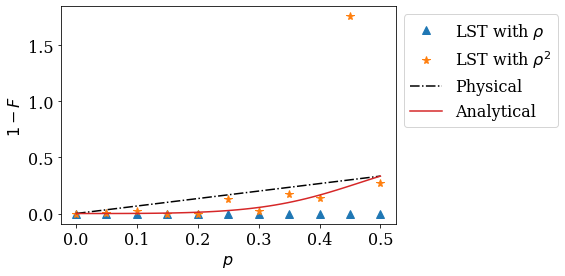

In [23]:
plt.plot(pvalues, 1 - fid_list, "^", markersize=8, label=r"LST with $\rho$")
plt.plot(pvalues, 1 - lst_vd_fids.real, "*", markersize=8, label=r"LST with $\rho^2$")
plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")
plt.plot(
    np.linspace(0, 0.5, 50), 1 - FL(np.linspace(0, 0.5, 50)), c="C3", label="Analytical"
)
# plt.ylim(0, 0.5)
plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend(bbox_to_anchor=(1,1));